# Face Obstruction Detection - Multi-Label

The purpose of this project is to perfrom multi label classification. We have a dataset where the images can belong to multiple classes. The images represent faces and object that obstruct those faces

## Import the dataset

Organize imports

In [53]:
import pandas as pd
import numpy as np
import cv2
import imghdr
import os
import pathlib
import json
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, SpatialDropout2D
import shutil
from keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from keras.models import load_model
from tensorflow.keras import regularizers
from keras import layers
from tensorflow import keras

Read the dataset. Here we have a csv file that hold's the id of the imagees and a one hot encoding of their labels

The images are stored under 'data/face-images/images' folder

In [54]:
images_folder = "./data/face-images/images"

df = pd.read_csv("data/face-images/dataset.csv")
df.head()

,id,glasses,hand,mask,none,other,sunglasses
0,i00001.jpg,1,0,0,0,0,0
1,i00002.jpg,1,0,0,0,0,0
2,i00003.jpg,1,0,0,0,0,0
3,i00004.jpg,1,0,0,0,0,0
4,i00005.jpg,1,1,0,0,0,0


Rearange the columns

In [55]:
df = df[['id', 'glasses', 'hand', 'mask', 'sunglasses', 'other', 'none']]
df.head()


,id,glasses,hand,mask,sunglasses,other,none
0,i00001.jpg,1,0,0,0,0,0
1,i00002.jpg,1,0,0,0,0,0
2,i00003.jpg,1,0,0,0,0,0
3,i00004.jpg,1,0,0,0,0,0
4,i00005.jpg,1,1,0,0,0,0


We need to add the image size and channels as features

In [56]:
def get_image_metadata(df_row):
    file_path = os.path.join(images_folder, df_row['id'])
    image = Image.open(file_path)
    width, height = image.size
    channels = image.mode
    return width, height, image.format, channels

df['image_width'], df['image_height'], df['format'], df['channels'] = zip(*df.apply(get_image_metadata, axis=1))

df.head()

,id,glasses,hand,mask,sunglasses,other,none,image_width,image_height,format,channels
0,i00001.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
1,i00002.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
2,i00003.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
3,i00004.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
4,i00005.jpg,1,1,0,0,0,0,256,256,JPEG,RGB


We want to see if we have different formats, channels and sizes

In [57]:
df['format'].value_counts(), df['channels'].value_counts()

(format
 JPEG    11871
 Name: count, dtype: int64,
 channels
 RGB    11871
 Name: count, dtype: int64)

We see that we have only JPEG format and RGB channels, this is good so far

Now we want to see what width and height we have for the images

#### Plotting the width distribution

We binned the images in different bins so we can better represent how they are distributed according to their size. The goal of this is to see  what would be a good fit for the image resize

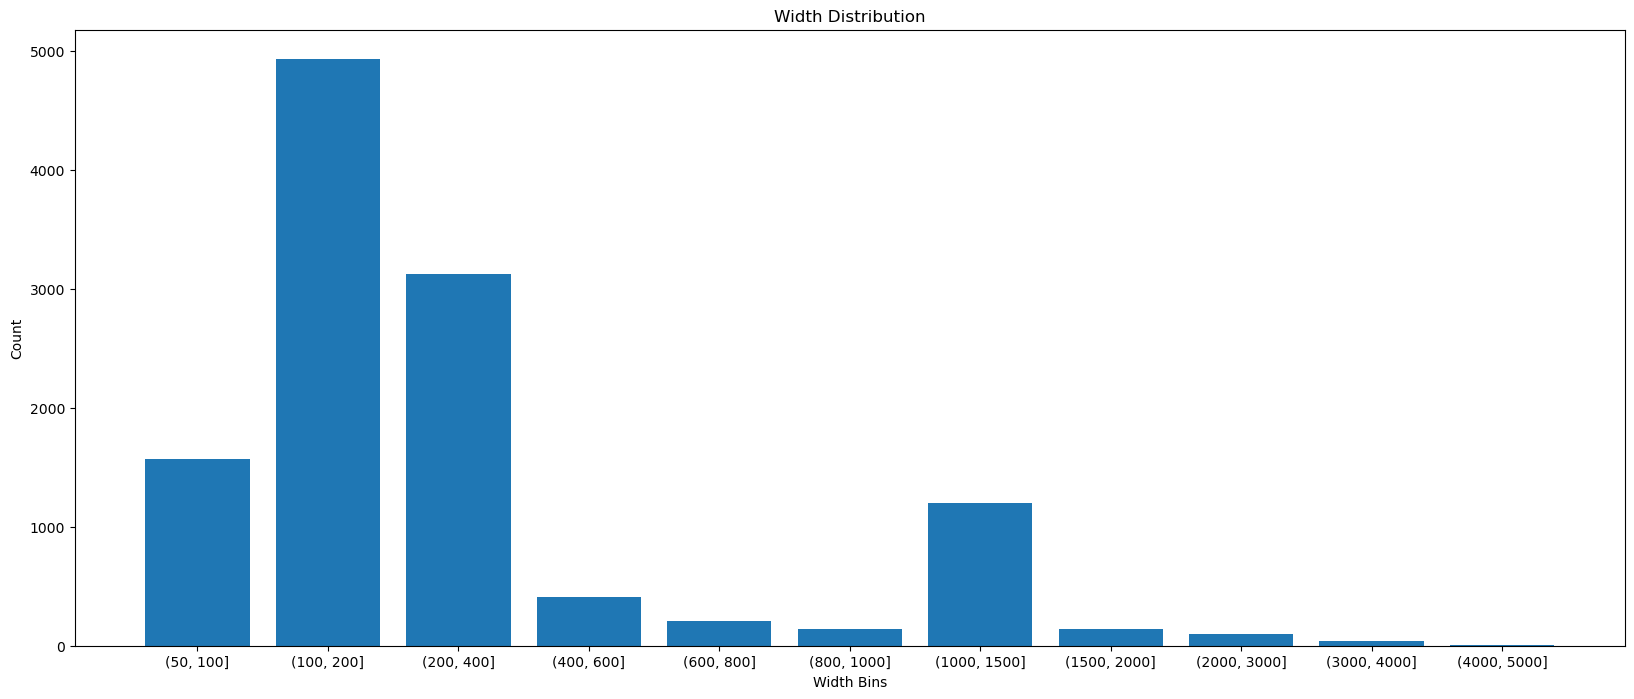

In [58]:
# Define bins for width data
bins = [50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000]  # Define the bin edges according to your requirements

# Bin the data
df['width_bin'] = pd.cut(df['image_width'], bins=bins)

# Count the occurrences in each bin
bin_counts = df['width_bin'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(20, 8))
plt.bar(bin_counts.index.astype(str), bin_counts.values)
plt.xlabel('Width Bins')
plt.ylabel('Count')
plt.title('Width Distribution')
plt.show()

Same for height

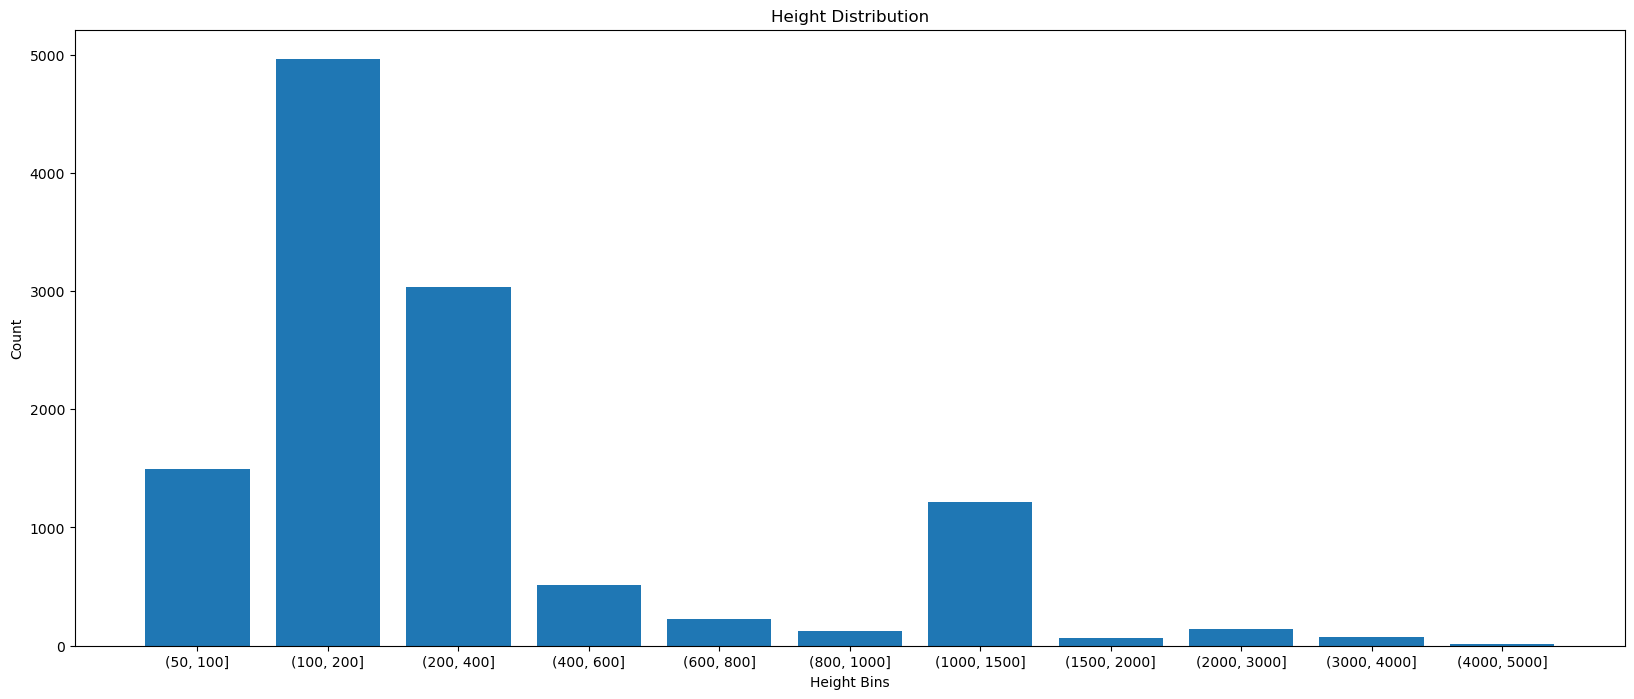

In [59]:
# Define bins for width data
bins = [50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000]  # Define the bin edges according to your requirements

# Bin the data
df['height_bin'] = pd.cut(df['image_height'], bins=bins)

# Count the occurrences in each bin
bin_counts = df['height_bin'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(20, 8))
plt.bar(bin_counts.index.astype(str), bin_counts.values)
plt.xlabel('Height Bins')
plt.ylabel('Count')
plt.title('Height Distribution')
plt.show()

In [60]:
df.drop(columns=['width_bin', 'height_bin'], inplace=True)

In [61]:
df.sort_values(by='image_width')

,id,glasses,hand,mask,sunglasses,other,none,image_width,image_height,format,channels
6128,i09932.jpg,0,0,0,0,0,1,51,51,JPEG,RGB
3330,i05173.jpg,1,0,1,0,0,0,56,90,JPEG,RGB
6778,i10582.jpg,0,0,0,0,0,1,58,58,JPEG,RGB
5326,i09130.jpg,0,0,0,0,0,1,58,58,JPEG,RGB
4372,i08176.jpg,0,0,0,0,1,1,59,59,JPEG,RGB
...,...,...,...,...,...,...,...,...,...,...,...
10441,i17697.jpg,0,0,0,1,0,0,4608,3440,JPEG,RGB
10442,i17698.jpg,0,0,0,1,0,0,4608,3440,JPEG,RGB
4105,i07360.jpg,0,0,1,0,0,0,4734,5412,JPEG,RGB
4056,i07311.jpg,0,0,1,0,0,0,4912,3264,JPEG,RGB


We want to resize some images to see how they looks after

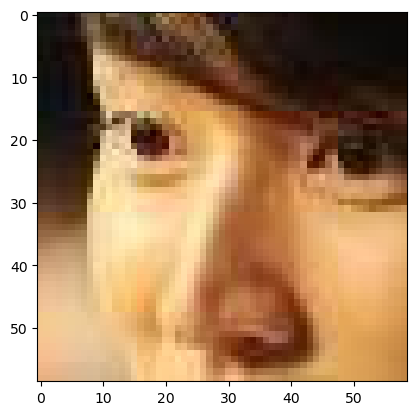

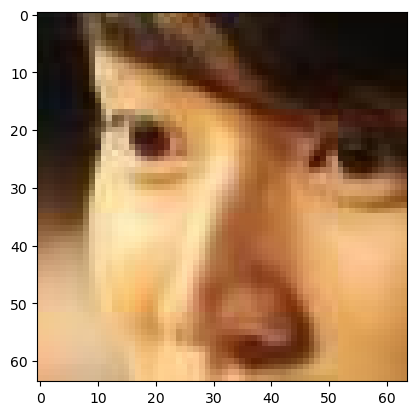

In [62]:
img_size = 64

def get_image(image_path):
    img = cv2.imread(image_path)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return im_rgb

new_image = get_image(os.path.join(images_folder, "i08176.jpg"))
plt.imshow(new_image)
plt.show()


def resize_image(image, height, width):
    return tf.image.resize(image, (height, width))

resized_image = resize_image(new_image, img_size, img_size)
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [63]:
df.sort_values(by='other')

,id,glasses,hand,mask,sunglasses,other,none,image_width,image_height,format,channels
0,i00001.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
7657,i11462.jpg,0,0,0,0,0,1,80,80,JPEG,RGB
7658,i11463.jpg,0,0,0,0,0,1,102,102,JPEG,RGB
7659,i11464.jpg,0,0,0,0,0,1,106,106,JPEG,RGB
7660,i11465.jpg,0,0,0,0,0,1,105,105,JPEG,RGB
...,...,...,...,...,...,...,...,...,...,...,...
1666,i01721.jpg,0,0,0,0,1,0,180,180,JPEG,RGB
9831,i16493.jpg,0,0,0,0,1,0,256,256,JPEG,RGB
1664,i01719.jpg,0,0,0,0,1,0,180,180,JPEG,RGB
1678,i01733.jpg,0,1,0,0,1,0,180,180,JPEG,RGB


Display a single image

In [64]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def show_image(images_folder, image):
    img_path = os.path.join(images_folder, image)
    img = Image.open(img_path)
    img.show()

#show_image(images_folder,'i01733.jpg')

We want to see the unique combination of labels per images

In [65]:
label_columns = ['glasses', 'hand', 'mask', 'sunglasses', 'other', 'none']

df['combined_labels'] = df[label_columns].apply(lambda x: '|'.join(map(str, x)), axis=1)

df['combined_labels'].value_counts()

combined_labels
0|0|0|0|0|1    5660
0|0|1|0|0|0    2073
0|0|0|1|0|0    1635
1|0|0|0|0|0     765
0|1|0|0|0|0     685
0|0|0|0|1|0     447
0|1|0|0|1|0     198
1|0|1|0|0|0     147
1|1|0|0|0|0      74
0|0|1|0|1|0      54
0|0|1|1|0|0      44
1|0|0|0|1|0      37
0|1|1|0|0|0      15
0|0|0|0|1|1       8
1|1|0|0|1|0       8
1|0|0|1|0|0       5
0|0|0|0|0|0       3
0|1|0|0|0|1       2
1|1|1|0|0|0       2
1|0|1|0|1|0       2
0|0|0|1|1|0       2
0|1|0|1|0|0       2
0|1|1|0|1|0       1
1|0|1|1|0|0       1
0|0|1|1|1|0       1
Name: count, dtype: int64

We think that the dataset is good and we can moove forward with these images to classify them. We want to perform multi label classification

## Multi label image classification

We need to split the dataset into three parts: 
- training
- validation
- testing


We need to resize the images

We need to convert the images into tesnors and batch them

We need to normalize the tensors from the batches


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(df, labels_columns, train_size=0.7, test_size=0.1, random_state=42):
    """
    Split the data into training, validation, and test sets.

    Parameters:
    - df: The DataFrame containing the data.
    - labels_columns: A list containing the names of columns containing labels.
    - train_size: The proportion of the dataset to include in the training set.
    - test_size: The proportion of the dataset to include in the test set.
    - random_state: The seed used by the random number generator.

    Returns:
    - A tuple containing three DataFrames: train_data, validation_data, and test_data.
    """

    # Split the data into training and the rest by combined labels
    train_data, rest_data = train_test_split(df, train_size=train_size, random_state=random_state)

    # Calculate the remaining percentage
    remaining_size = 1.0 - train_size

    # Split the remaining data into testing and evaluation by combined labels
    valid_data, test_data = train_test_split(rest_data, test_size=test_size / remaining_size, random_state=random_state)

    return train_data, valid_data, test_data

# Usage example:
# Assuming 'df' is your DataFrame containing the data, and 'labels_columns' is a list of columns containing labels
train_data, valid_data, test_data = split_data(df, label_columns)

## Load the data with a caching system

We do this to imrpove the performance and avoid I/O bottlenecks when reading from disk. This improves the performance of the training process somewhere around 40%

In [67]:
from sklearn.utils import shuffle

seed = 42
image_size = 200
batch_size = 1

def custom_data_loader(dataframe, labels_column, batch_size, image_size):
    
    dataframe['paths'] = images_folder + "/" + df['id']
    file_paths = file_paths = dataframe['paths'].tolist()  # List of file paths
    labels = dataframe[labels_column].values.tolist()
    file_paths, labels = shuffle(file_paths, labels, random_state=seed)
    labels = np.array(labels)

    # group the images and labels into batches of the given size
    for i in range(0, len(file_paths), batch_size):
        batch_file_paths = file_paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        batch_images = []
        for file_path in batch_file_paths:

            # Load and preprocess image - Resize the images, convert them to numbers/arrays and rescale them
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=(image_size, image_size))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = img / 255.

            batch_images.append(img)
                
        yield np.array(batch_images), np.array(batch_labels)

Create a tensor dataset using the previous method, the tensorshape will have the images represented as float values and the labels as integers

In [68]:
def load_dataset(dataframe, labels_columns, batch_size = batch_size, image_size=image_size):
    
    dataset = tf.data.Dataset.from_generator(
        lambda: custom_data_loader(dataframe, labels_columns, batch_size, image_size),
        output_types=(tf.float32, tf.int32),
        output_shapes=(tf.TensorShape([None, image_size, image_size, 3]), tf.TensorShape([None, 6]))
        )

    return dataset

Get the datasets that we need

In [69]:
train_dataset = load_dataset(train_data, label_columns)
validation_dataset = load_dataset(valid_data, label_columns)
testing_dataset = load_dataset(test_data, label_columns)

Cache the datasets for training and validation that are used when we train

In [72]:
train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(tf.data.AUTOTUNE)

Now we have 3 datasets for training, validation and testing

Label mapping 

In [75]:
label_mapping = {
    'glasses': 0,
    'hand': 1,
    'mask': 2,
    'sunglasses': 3,
    'other': 4,
    'none': 5
}

### Augmentation layers

We can introduce more entropy in the dataset by adding an augmentation layer. This will help the model visualize the images from different perspectives

In [76]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(image_size, image_size, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

### Build the model

Here we defined different architectures to experiment with them and choose the best one in the end

In [83]:
num_classes = len(label_columns)

small_model = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_size, image_size, 3)),
  MaxPooling2D(),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(num_classes, activation='sigmoid')
]

medium_model = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_size, image_size, 3)),
  MaxPooling2D(),
  Conv2D(32, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(num_classes, activation='sigmoid')
]

large_model = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_size, image_size, 3)),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Conv2D(32, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Conv2D(64, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Conv2D(128, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='sigmoid')
]

  extra_large_model = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_size, image_size, 3)),
  MaxPooling2D(),
  layers.Dropout(0.4),
  Conv2D(32, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.4),
  Conv2D(64, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.4),
  Conv2D(128, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.4),
  Flatten(),
  Dense(256, activation='relu'),
  layers.Dropout(0.4),
  Dense(num_classes, activation='sigmoid')
]

regularized_model = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_size, image_size, 3),
         kernel_regularizer=regularizers.l2(0.001)),
  MaxPooling2D(),
  Conv2D(32, (3,3), padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.001)),
  MaxPooling2D(),
  Conv2D(64, (3,3), padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.001)),
  MaxPooling2D(),
  Conv2D(128, (3,3), padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.001)),
  MaxPooling2D(),
  Conv2D(128, (3,3), padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.001)),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu',  kernel_regularizer=regularizers.l2(0.001)),
  Dropout(0.3),
  Dense(num_classes, activation='sigmoid')
]

best_model = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_size, image_size, 3)),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Conv2D(32, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Conv2D(64, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Conv2D(128, (3,3), padding='same', activation='relu'),
  MaxPooling2D(),
  layers.Dropout(0.3),
  Flatten(),
  Dense(256, activation='relu'),
  layers.Dropout(0.3),
  Dense(num_classes, activation='sigmoid')
]

model = keras.Sequential([
    data_augmentation,
    *best_model
])

Compile the model

We compile the model by adding the optimizer and we also have a way to decay the learning rate gradually. We haven't used this because as we experimented with it we noticed that over time the learning rate becomse 0 and the model doesn't learn. We will just keep it for reference

In [84]:
def compile_model(model, learning_rate=0.001): 
    # use this only when you reach overfitting
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=1500,  # Adjust decay steps as needed
        decay_rate=0.01,     # Adjust decay rate as needed
        staircase=True)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    model.summary()    
    return model

model = compile_model(model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_87 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 75, 75, 16)        0         
                                                                 
 conv2d_88 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                 

### Define callbakcs

These callbacks will be exectued at the end of each epoch. We have a logging callback, an early stopping callback and a model checkpoint callback

In [85]:
logdir = 'logs'

# Clean logs data before running training
if os.path.exists(logdir):
    shutil.rmtree(logdir)

# logger callback
logger_callback = TensorBoard(log_dir=logdir)

# monitor the training loss and stop training if the loss doesn't improve for 4 consecutive epochs
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4) 

# checkpoint callback - save the best model callback
def create_model_checkpoint(model_path, metric='val_accuracy') -> ModelCheckpoint:
    model_checkpoint = ModelCheckpoint(model_path, monitor=metric, verbose=1, save_best_only=True)
    return model_checkpoint

def get_logger_callback(model_name):
    return TensorBoard(log_dir=os.path.join(logdir, model_name))  
    

### Training 

Here we define the training method and we add the callbacks

In [86]:
def fit_model(model, name, epochs):
    history = model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs=epochs,
                        callbacks=[
                                  get_logger_callback(name),
                                  early_stopping_callback,
                                  create_model_checkpoint(f'./models/{name}.h5')])
    return history                              

We will hold the training history in this dictionary

In [87]:
size_histories = {}

In [88]:
size_histories['large'] = fit_model(model, 'sizes-large-3', 30)

Epoch 1/30


    260/Unknown - 97s 340ms/step - loss: 0.3076 - precision_5: 0.7575 - recall_5: 0.5040 - accuracy: 0.6306
Epoch 1: val_accuracy improved from -inf to 0.71146, saving model to ./models\sizes-large-3.h5
260/260 [==============================] - 101s 355ms/step - loss: 0.3076 - precision_5: 0.7575 - recall_5: 0.5040 - accuracy: 0.6306 - val_loss: 0.2883 - val_precision_5: 0.8417 - val_recall_5: 0.6077 - val_accuracy: 0.7115
Epoch 2/30
260/260 [==============================] - ETA: 0s - loss: 0.2341 - precision_5: 0.8449 - recall_5: 0.6175 - accuracy: 0.7261
Epoch 2: val_accuracy improved from 0.71146 to 0.73505, saving model to ./models\sizes-large-3.h5
260/260 [==============================] - 106s 409ms/step - loss: 0.2341 - precision_5: 0.8449 - recall_5: 0.6175 - accuracy: 0.7261 - val_loss: 0.2345 - val_precision_5: 0.8552 - val_recall_5: 0.6328 - val_accuracy: 0.7350
Epoch 3/30
260/260 [==============================] - ETA: 0s - loss: 0.2113 - precision_5: 0.8656 - recall_5: 0

### Plot model performance

In [89]:
history_metrics = size_histories['large'].history

We have a method for writing the performance metrics into an external json file and also we have the methods for plotting the metrics

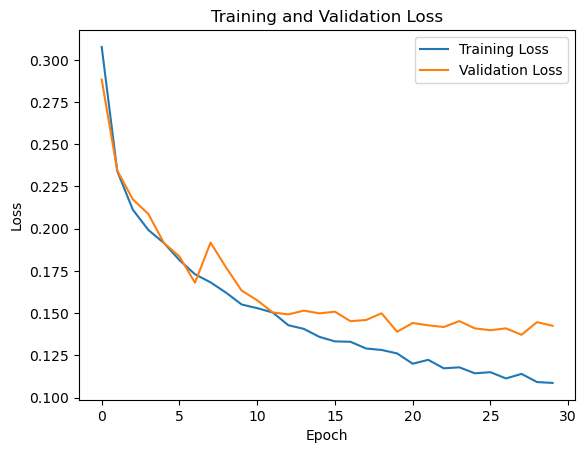

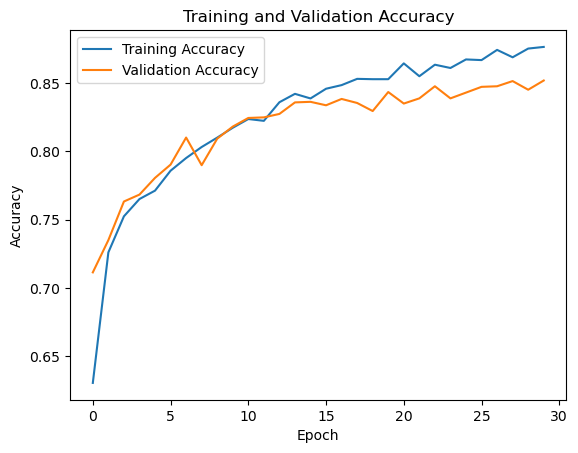

In [91]:
file_path = './metrics/sizes-large_history_metrics.json'

# Function to load history data from a JSON file
def load_history_from_json(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as json_file:
            return json.load(json_file)
    else:
        return {}

# Function to save history data to a JSON file
def save_history_to_json(data, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file)

# Function to plot history loss data
def plot_history_loss(history):
    # Plot loss
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Function to plot history accuracy data
def plot_history_acc(history):
    # Plot accuracy
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Load existing history
existing_history = load_history_from_json(file_path)

# Run your model and obtain new history data (replace this with your actual model training)
new_history = history_metrics

# Merge new history with existing history
for key in new_history:
    if key in existing_history:
        existing_history[key].extend(new_history[key])
    else:
        existing_history[key] = new_history[key]

# Save the combined history back to the JSON file
save_history_to_json(existing_history, file_path)

# Plot the combined history
plot_history_loss(existing_history)
plot_history_acc(existing_history)

Plot history metrics

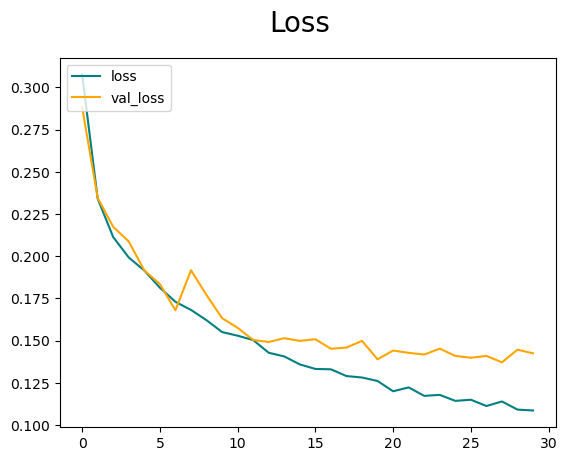

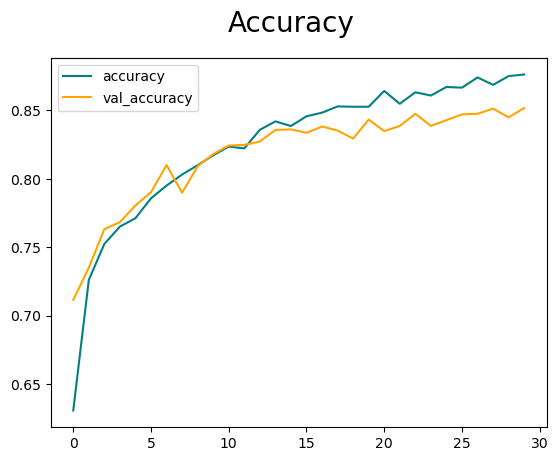

In [92]:

def plot_metrics(history, metric):
    if metric not in history:
        raise ValueError(f"{metric} not found in history. Available metrics: {', '.join(history.keys())}")
    
    fig = plt.figure()
    plt.plot(history[metric], color='teal', label=metric)
    val_metric = 'val_' + metric
    plt.plot(history[val_metric], color='orange', label=val_metric)
    fig.suptitle(metric.capitalize(), fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

plot_metrics(existing_history, metric='loss')
plot_metrics(existing_history, metric='accuracy') 


Here we plot all the metrics in a single plot for both training and validation

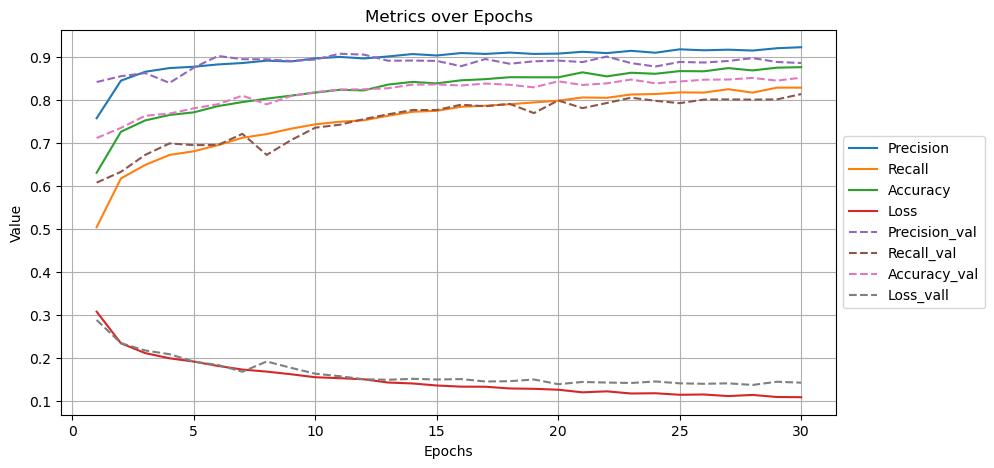

In [93]:

precision_key = [key for key in history_metrics.keys() if key.startswith('precision_')][0]
recall_key = [key for key in history_metrics.keys() if key.startswith('recall_')][0]

val_precision_key = [key for key in history_metrics.keys() if key.startswith('val_precision_')][0]
val_recall_key = [key for key in history_metrics.keys() if key.startswith('val_recall_')][0]

precision = history_metrics[precision_key]
recall = history_metrics[recall_key]
accuracy = history_metrics['accuracy']
loss = history_metrics['loss']

precision_val = history_metrics[val_precision_key]
recall_val = history_metrics[val_recall_key]
accuracy_val = history_metrics['val_accuracy']
loss_val = history_metrics['val_loss']

# Creating an array of epoch numbers
epochs = np.arange(1, len(precision) + 1)

# Plotting the metrics
plt.figure(figsize=(10, 5))

#Training metrics
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, loss, label='Loss')

#Validation metrics
plt.plot(epochs, precision_val, label='Precision_val',  linestyle='--')
plt.plot(epochs, recall_val, label='Recall_val',  linestyle='--')
plt.plot(epochs, accuracy_val, label='Accuracy_val',  linestyle='--')
plt.plot(epochs, loss_val, label='Loss_vall', linestyle='--')

plt.title('Metrics over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

### Load the model

In [96]:
saved_model = load_model(os.path.join('models', 'sizes-large-3.h5'))

### Predict on testing data 

In [97]:
precision = Precision()
recall = Recall()
accuracy = Accuracy()

# Lists to store true and predicted labels for F1-score calculation
true_labels = []
predicted_labels = []

limit = 100
counter = 0

for batch in testing_dataset:
    X, y = batch 
    yhat = saved_model.predict(X)

    # Obtain the predicted class labels (the classes with the highest probability for each sample)
    predicted_class = np.argmax(yhat, axis=1)
    
    # Convert the label to one-hot encoding
    predicted_one_hot = tf.one_hot(predicted_class, depth=num_classes)
    
    precision.update_state(y, predicted_one_hot)
    recall.update_state(y, predicted_one_hot)
    accuracy.update_state(y, predicted_one_hot)

    true_labels.extend(y)
    predicted_labels.extend(predicted_one_hot)

    counter += 1
    if counter >= limit:
        break

1/1 [==============================] - 0s 150ms/step


We grab the performance metrics obtained after we predicted on the testing data

In [98]:
# Compute F1-score
f1 = f1_score(true_labels, predicted_labels, average='micro')

print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}, F1-score: {f1}')

# Optionally, you can print the classification report for more detailed information
report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)

Precision: 0.8619528412818909, Recall: 0.8185451626777649, Accuracy: 0.9451459050178528, F1-score: 0.8396883968839689
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.60      0.67       109
           1       0.67      0.58      0.62       107
           2       0.84      0.84      0.84       230
           3       0.91      0.89      0.90       167
           4       0.29      0.19      0.23        64
           5       0.95      0.95      0.95       574

   micro avg       0.86      0.82      0.84      1251
   macro avg       0.74      0.67      0.70      1251
weighted avg       0.85      0.82      0.83      1251
 samples avg       0.86      0.84      0.85      1251



c:\Users\Hori\miniconda3\envs\image-classification-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We will plot a confusion matrix 

Confusion Matrix:
[[[1058   21]
  [  44   65]]

 [[1050   31]
  [  45   62]]

 [[ 920   38]
  [  36  194]]

 [[1007   14]
  [  19  148]]

 [[1095   29]
  [  52   12]]

 [[ 583   31]
  [  31  543]]]


<Figure size 1000x800 with 0 Axes>

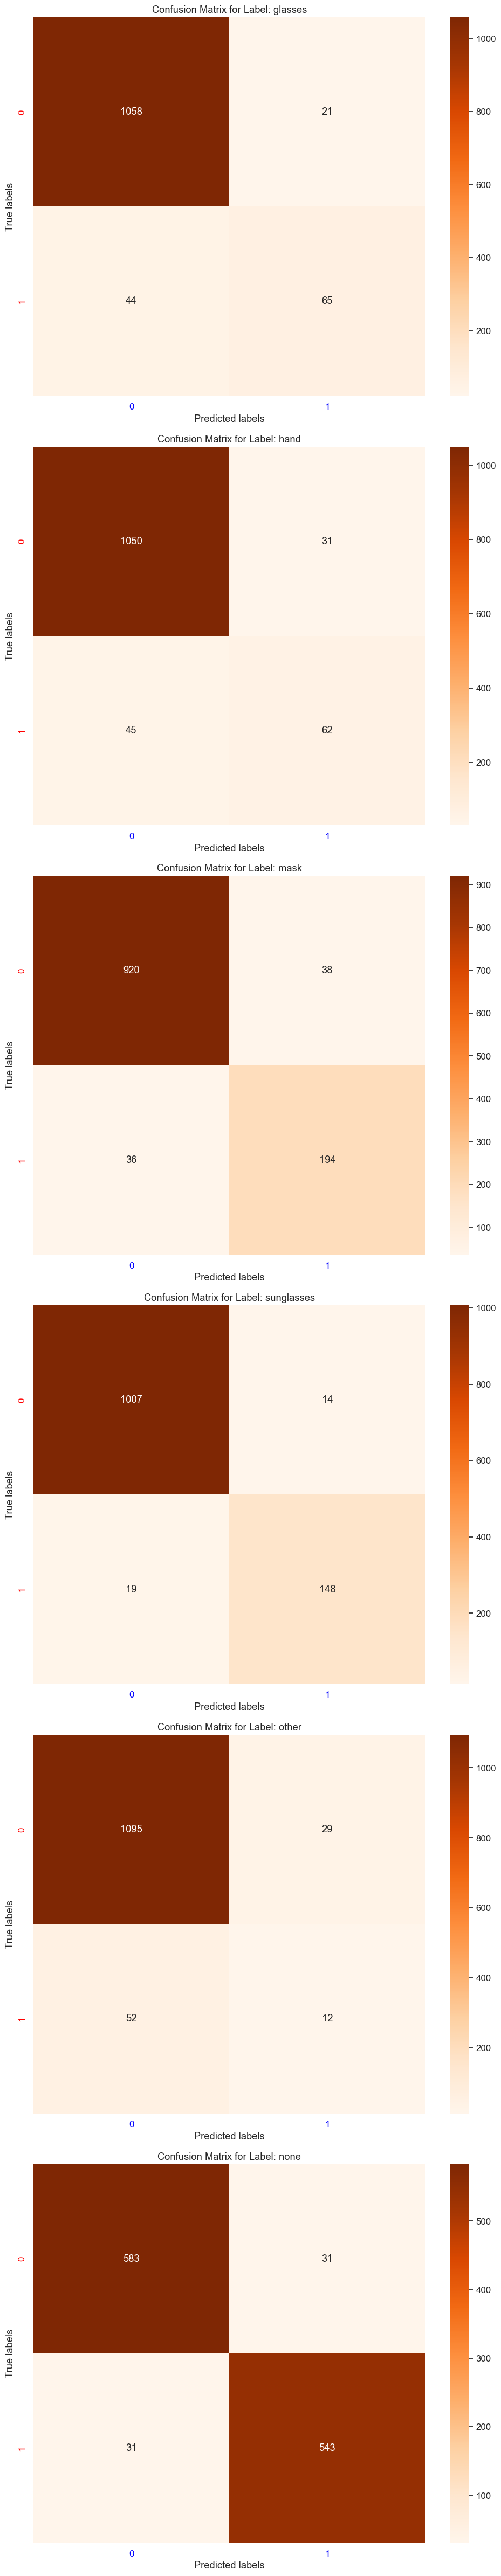

In [99]:
# Compute confusion matrix
cm = multilabel_confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.1)

# Plot confusion matrix for each label
fig, axes = plt.subplots(nrows=len(label_mapping), ncols=1, figsize=(10, 8 * len(label_mapping)))
for i, (label_cm, label_name) in enumerate(zip(cm, label_mapping)):
    ax = axes[i]
    sns.heatmap(label_cm, annot=True, cmap='Oranges', fmt='d', ax=ax)
    ax.set_title(f'Confusion Matrix for Label: {label_name}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.tick_params(axis='x', colors='blue')
    ax.tick_params(axis='y', colors='red')

plt.tight_layout()
plt.show()